# Proactive Churn Prediction using Logistic Regression 

First, we import all necessary packages we need.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

%matplotlib inline

In [5]:
def ltv(nmonth, revenue, churn, cost = 0, onetime_cost = 0, cont_cost = 0, annual_discount = 0.1, begin = False, Type = 'base'):
    period = np.arange(nmonth + 1)
    revenue = np.concatenate([[0], np.repeat(revenue, nmonth)])
    cost = np.concatenate([[0], np.repeat(cost, nmonth)])
    onetime_cost = np.concatenate([[0, onetime_cost], np.repeat(0, nmonth -1)])
    cont_cost = np.concatenate([[0], np.repeat(cont_cost, nmonth)])
    churn_rate = np.concatenate([[0], np.repeat(churn, nmonth)])
    active_rate = np.concatenate([[1], np.repeat(np.nan, nmonth)])
    expected_profit = np.concatenate([[0], np.repeat(np.nan, nmonth)])
    PV = np.concatenate([[0], np.repeat(np.nan, nmonth)])
    LTV = np.concatenate([[0], np.repeat(np.nan, nmonth)])
    Type = np.repeat(Type, nmonth+1)
    
    df = pd.DataFrame([
        Type, period, revenue, cost, onetime_cost, cont_cost, churn_rate, active_rate, expected_profit, PV, LTV
    ],
        index = ['Type','period', 'revenue', 'cost','onetime_cost', 'cont_cost', 'churn_rate', 'active_rate', 'expected_profit', 'PV', 'LTV'])
    for i in range(nmonth):
        df.loc['active_rate'][i+1] = (1 - df.loc['churn_rate'][i+1]) ** df.loc['period'][i]
        df.loc['expected_profit'][i+1] = df.loc['active_rate'][i+1] * df.loc['revenue'][i+1] - df.loc['cost'][i+1] -df.loc['cont_cost'][i+1] - df.loc['onetime_cost'][i+1]
        if begin:
            df.loc['PV'][i+1] = df.loc['expected_profit'][i+1] / (1 + ((1 + annual_discount)**(1 / 12) - 1)) ** (df.loc['period'][i+1] - 1)
        else:
            df.loc['PV'][i+1] = df.loc['expected_profit'][i+1] / (1 + ((1 + annual_discount)**(1 / 12) - 1)) ** (df.loc['period'][i+1])
    df.loc['LTV'] = np.cumsum(df.loc['PV'])
    return df

Let's take a brief look at the data.

In [6]:
data = pd.read_csv('data.csv')

In [7]:
data.head()

,customer,churn,changer,changem,revenue,mou,overage,roam,threeway,months,...,smartphone,children,highcreditr,mcycle,car,travel,region,occupation,training,representative
0,U86940794,yes,109,49,62,600,141,0,0,8,...,yes,no,no,no,no,no,CS,other,0.0,0
1,U56788559,no,0,2,54,146,0,0,0,8,...,yes,no,no,no,no,no,SW,other,0.0,0
2,U47928407,no,0,-3,39,1158,96,0,1,9,...,yes,no,no,yes,no,yes,SE,professional,NaN,1
3,U75794640,no,0,-17,50,560,0,0,0,37,...,yes,no,yes,yes,no,no,CS,professional,1.0,0
4,U41010771,no,-2,-8,100,1888,112,9,0,20,...,yes,yes,no,yes,yes,no,SW,other,NaN,1


In [8]:
pd.concat([data.dtypes, data.nunique()], axis =1,keys=['dtypes','nunique'])

,dtypes,nunique
customer,object,69000
churn,object,2
changer,int64,346
changem,int64,548
revenue,int64,450
mou,int64,2883
overage,int64,230
roam,int64,133
threeway,int64,38
months,int64,56


We notice that, all **"object"** fields except for `region` and `occupation` have only two unique values ("yes" and "no"), so we can further encode them into binary variables. 

In [9]:
binary_vars = ['churn', 'refurb', 'smartphone', 'children', 'highcreditr', 'mcycle', 'car', 'travel']
mapping = {'yes':1, 'no':0}
binary = data[binary_vars].apply(lambda x: x.map(mapping))
data[binary_vars] = binary

In [10]:
categorical_vars = ['region', 'occupation']
category = pd.get_dummies(data[categorical_vars])
data.drop(categorical_vars, axis=1, inplace=True)
data = pd.concat([data, category], axis=1)

In [11]:
rep = data[data.representative == 1].drop(['customer','training', 'representative'], axis = 1) # split the representative data and drop unique identifier
rep_wrk = rep.copy()

In [12]:
rep.head()

,churn,changer,changem,revenue,mou,overage,roam,threeway,months,uniqsubs,...,region_SE,region_SW,occupation_clerical,occupation_crafts,occupation_homemaker,occupation_other,occupation_professional,occupation_retired,occupation_selfemployed,occupation_student
2,0,0,-3,39,1158,96,0,1,9,1,...,1,0,0,0,0,0,1,0,0,0
4,0,-2,-8,100,1888,112,9,0,20,3,...,0,1,0,0,0,1,0,0,0,0
5,0,-2,-11,45,504,73,2,0,11,1,...,0,0,0,0,0,1,0,0,0,0
7,0,96,62,60,777,133,0,1,7,1,...,0,0,0,0,0,1,0,0,0,0
10,0,1,109,30,19,0,0,0,13,1,...,0,0,0,0,0,1,0,0,0,0


In [13]:
data = data[data.representative == 0].drop(['customer','representative'], axis = 1)

In [14]:
data.describe()

,churn,changer,changem,revenue,mou,overage,roam,threeway,months,uniqsubs,...,region_SE,region_SW,occupation_clerical,occupation_crafts,occupation_homemaker,occupation_other,occupation_professional,occupation_retired,occupation_selfemployed,occupation_student
count,39000.000000,39000.000000,39000.000000,39000.000000,39000.000000,39000.000000,39000.000000,39000.000000,39000.000000,39000.000000,...,39000.000000,39000.000000,39000.000000,39000.000000,39000.000000,39000.000000,39000.000000,39000.000000,39000.000000,39000.000000
mean,0.500000,8.817103,15.096615,58.653718,514.326308,62.959231,1.201359,0.260795,18.917077,1.545308,...,0.200000,0.196795,0.020077,0.029000,0.002615,0.735205,0.173615,0.014308,0.017897,0.007282
std,0.500006,29.323700,51.217486,44.157255,524.809880,68.526036,8.255571,1.079977,9.525395,0.885709,...,0.400005,0.397581,0.140265,0.167809,0.051075,0.441230,0.378783,0.118758,0.132580,0.085025
min,0.000000,-62.000000,-79.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-2.000000,-10.000000,33.000000,152.000000,0.000000,0.000000,0.000000,12.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.000000,-1.000000,48.000000,356.000000,37.000000,0.000000,0.000000,17.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,4.000000,27.000000,71.000000,703.000000,126.000000,0.000000,0.000000,24.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,364.000000,538.000000,861.000000,7668.000000,283.000000,851.000000,56.000000,61.000000,18.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We plot the distribution of several fields selected:

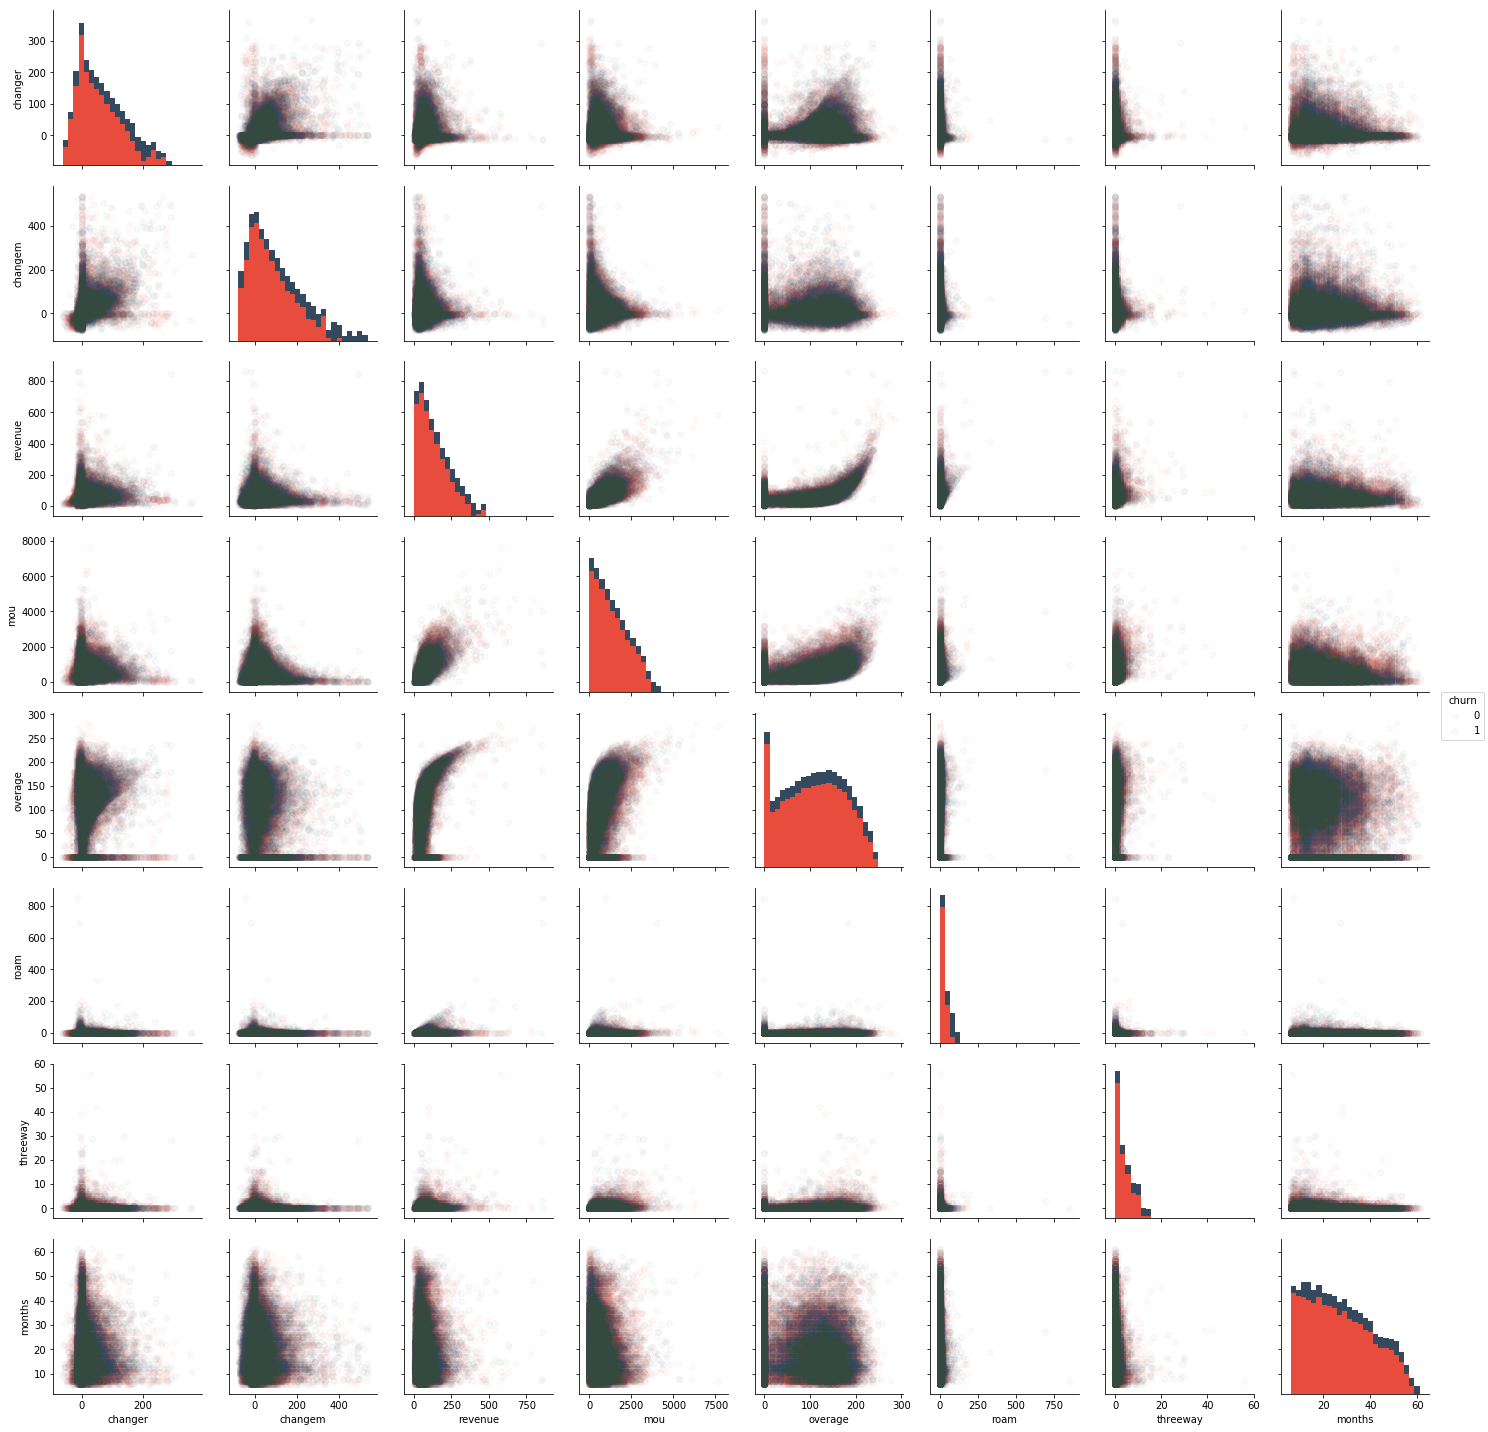

In [43]:
var = ['changer', 'changem', 'revenue', 'mou', 'overage', 'roam', 'threeway', 'months']
g = sns.PairGrid(data=data, vars=var, hue = 'churn', palette=["#e74c3c", "#34495e"])
g.map_diag(plt.hist, bins = 25, log=True)
g.map_offdiag(plt.scatter, alpha = 0.03)
g.add_legend();
plt.savefig('pairplot.png')

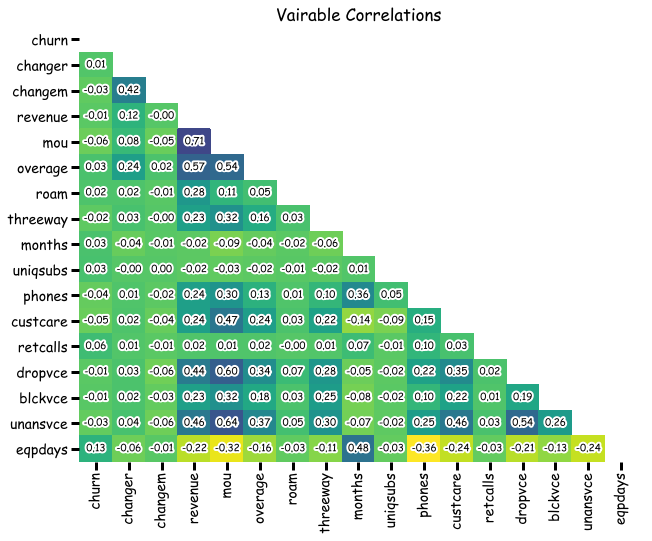

In [44]:
numeric_vars = ['churn', 'changer', 'changem', 'revenue', 'mou', 'overage', 'roam', 'threeway', 'months', 'uniqsubs', 'phones', 'custcare', 'retcalls', 'dropvce', 'blckvce', 'unansvce','eqpdays']
numeric_corr = data[numeric_vars].corr()
mask = np.zeros_like(numeric_corr)
mask[np.triu_indices_from(mask)]=True


with plt.xkcd():
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_corr, cmap='viridis_r', vmin=numeric_corr.min().min(), vmax=numeric_corr.max().max(), cbar = False,mask=mask, annot=True, fmt='.2f',annot_kws={'size':10, 'color':'black'})
    plt.title('Vairable Correlations');
    plt.savefig('corrplot.png')

In [17]:
train = data[data.training == 1].drop('training', axis=1)  # split the training data and drop unique identifier
y_train = train.churn
train.drop('churn', axis = 1, inplace=True)

In [18]:
valid = data[data.training == 0].drop('training', axis=1) # split the validation data and drop unique identifier
y_valid = valid.churn
valid.drop('churn', axis = 1, inplace=True)

In [19]:
numeric_vars = ['changer', 'changem', 'revenue', 'mou', 'overage', 'roam', 'threeway', 'months', 'uniqsubs', 'phones', 'custcare', 'retcalls', 'dropvce', 'blckvce', 'unansvce','eqpdays']
numeric_train = train[numeric_vars]
numeric_valid = valid[numeric_vars]

In [20]:
std_scaler = StandardScaler()
train[numeric_vars] = std_scaler.fit_transform(numeric_train) / 2
valid[numeric_vars] = std_scaler.transform(numeric_valid) / 2

We then estimate a logit model, and calculate the Odds ratio of each variable.

In [21]:
logit = LogisticRegression(penalty='l1')
logit.fit(train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Check overfitting

In [22]:
logit.score(train, y_train)

0.59824175824175829

In [23]:
logit.score(valid, y_valid)

0.5936752136752137

We calculate the odds and importance of each variable

In [24]:
coef_ = pd.Series(logit.coef_[0])
variables = pd.Series(train.columns.values)
coef = pd.concat([variables, coef_], axis=1,keys=['variable', 'coefficient'])
coef['odds'] = np.exp(coef['coefficient'])
def trans(x):
    if x > 1:
        return x
    else:
        return 1 / x
coef['importance'] = coef['odds'].apply(lambda x: trans(x))
coef = coef.sort_values('importance', ascending=False)

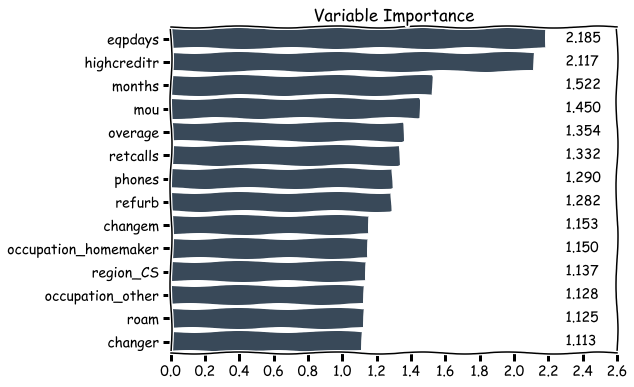

In [45]:
with plt.xkcd():
    plt.figure(figsize=(8,6))
    g= sns.barplot(data=coef[coef.importance > 1.1], x='importance',y='variable', color = "#34495e")
    plt.xticks(np.arange(0, 2.7, 0.2))
    plt.ylabel('')
    plt.xlabel('')
    plt.title('Variable Importance')
    locs, labels = plt.yticks()
    for loc, label in zip(locs, labels):
        importance = coef[coef.variable == label.get_text()]['importance']
        pct_string = '{:0.3f}'.format(importance.values[0])
        plt.text(2.3, loc, pct_string, color = 'black', va='center')
    plt.savefig('importanceplot.png')

Sample interpretation:
* `eqpdays`: for one more day that the customer owned the current equipment, the odds of customer churn will increase by a factor of 2.19.
* `highcreditr`: for customers who have high creadit rating, the odds of customer churn will decrease by a factor of 0.47.
* `months`: for one more month the customer has had service, the odds of customer churn will decrease by a factor of 0.66

**Action 1:**

For those who have owned their current equipment for more than 360 days, send them message to renew the equipment

*Assumption:*
* 10% of customers who receive the message will swith to a new phone
* The cost for the company is one time cost of $150.
* The average revenue per customer in this group remains the same

In [26]:
baseline_churn_rate = rep[rep.eqpdays > 360]['churn'].mean()
print('The baseline churn rate of customers who have owned the device for more than 360 days is {:.2f}%'.format(baseline_churn_rate * 100))
new_phone_index = rep.eqpdays > 360
new_phone = rep[new_phone_index]

The baseline churn rate of customers who have owned the device for more than 360 days is 2.75%


In [27]:
def switch_phone(x):
    if np.random.rand() <= 0.1:
        x = 0
    return x

new_phone_numeric = new_phone[numeric_vars].drop('eqpdays',axis=1)
eqpdays = new_phone['eqpdays'].apply(lambda x:switch_phone(x))
new_phone_cat = new_phone.drop(numeric_vars,axis=1)

In [28]:
new_phone_numeric = pd.concat([new_phone_numeric, eqpdays], axis=1)
new_phone_numeric.loc[:,:] = std_scaler.transform(new_phone_numeric) / 2
new_phone = pd.concat([new_phone_numeric, new_phone_cat], axis=1)

In [29]:
y_new_phone = new_phone.churn
new_phone.drop('churn', inplace=True, axis=1)

In [30]:
p = logit.predict_proba(new_phone)[:, 0]
p = p / (p + (1 - p) * (1 - 0.02) / 0.02)
new_phone['pred'] = p

In [31]:
predict_churn_rate = new_phone['pred'].mean()
print('After contact, the predicted average churn rate is estimated to be {:.2f}%'.format(predict_churn_rate * 100))

After contact, the predicted average churn rate is estimated to be 2.14%


In [32]:
average_rev = rep[new_phone_index]['revenue'].mean()
print('The average revenue of this group of customers is ${:.2f}'.format(average_rev))

The average revenue of this group of customers is $50.41


In [33]:
new_ltv = ltv(nmonth=60, revenue=average_rev, churn=predict_churn_rate, onetime_cost=15, Type='new').transpose() #since 10% will have $150, so on average, onetime cost is $15

In [34]:
base_ltv = ltv(nmonth=60, revenue=average_rev, churn=baseline_churn_rate).transpose()

In [35]:
summary = pd.concat([base_ltv, new_ltv])

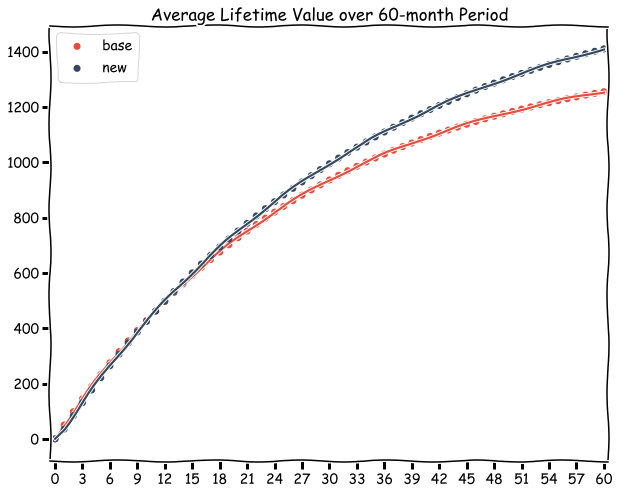

In [46]:
with plt.xkcd():
    plt.figure(figsize=(10,8))
    labels = np.arange(0, 63, 3)
    g = sns.pointplot(data=summary, x='period', y='LTV', hue='Type', markers='o', scale=0.6, palette=["#e74c3c", "#34495e"])
    g.set_xticks(labels)
    g.set_xticklabels(labels)
    g.legend(loc='best')
    plt.xlabel('')
    plt.ylabel('')
    plt.title('Average Lifetime Value over 60-month Period');
    plt.savefig('LTVplot.png')

In [62]:
month_12 = (new_ltv.iloc[12]['LTV'] - base_ltv.iloc[12]['LTV'])/base_ltv.iloc[12]['LTV'] * 100
month_24 = (new_ltv.iloc[24]['LTV'] - base_ltv.iloc[24]['LTV'])/base_ltv.iloc[24]['LTV'] * 100
month_36 = (new_ltv.iloc[36]['LTV'] - base_ltv.iloc[36]['LTV'])/base_ltv.iloc[36]['LTV'] * 100
month_48 = (new_ltv.iloc[48]['LTV'] - base_ltv.iloc[48]['LTV'])/base_ltv.iloc[48]['LTV'] * 100
month_60 = (new_ltv.iloc[60]['LTV'] - base_ltv.iloc[60]['LTV'])/base_ltv.iloc[60]['LTV'] * 100
print('Keeping all else equal:\n')
print('The 12-month average LTV for a customer will reach ${:.2f}, increase by {:.2f}% compare to the base LTV;'.format(new_ltv.iloc[12]['LTV'], month_12))
print('The 24-month average LTV for a customer will reach ${:.2f}, increase by {:.2f}% compare to the base LTV;'.format(new_ltv.iloc[24]['LTV'], month_24))
print('The 36-month average LTV for a customer will reach ${:.2f}, increase by {:.2f}% compare to the base LTV;'.format(new_ltv.iloc[36]['LTV'], month_36))
print('The 48-month average LTV for a customer will reach ${:.2f}, increase by {:.2f}% compare to the base LTV;'.format(new_ltv.iloc[48]['LTV'], month_48))
print('The 60-month average LTV for a customer will reach ${:.2f}, increase by {:.2f}% compare to the base LTV.'.format(new_ltv.iloc[60]['LTV'], month_60))

Keeping all else equal:

The 12-month average LTV for a customer will reach $497.77, increase by 0.25% compare to the base LTV;
The 24-month average LTV for a customer will reach $857.17, increase by 4.61% compare to the base LTV;
The 36-month average LTV for a customer will reach $1109.14, increase by 7.74% compare to the base LTV;
The 48-month average LTV for a customer will reach $1285.80, increase by 10.27% compare to the base LTV;
The 60-month average LTV for a customer will reach $1409.64, increase by 12.33% compare to the base LTV.


**Summary:**
Based on the LTV analysis, keeping all else equal, the new average LTV of a customer will exceed the base LTV at around 12-month.

Alternative, AdaboostClassifier

In [37]:
clf_ada = AdaBoostClassifier(learning_rate=0.01,n_estimators=1000)
clf_ada.fit(train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.01, n_estimators=1000, random_state=None)

In [38]:
clf_ada.score(train, y_train)

0.62432234432234435

In [39]:
clf_ada.score(valid, y_valid)

0.61991452991452989

In [40]:
importance = pd.Series(clf_ada.feature_importances_)
variables = pd.Series(train.columns.values)
importance = pd.concat([variables, coef_], axis=1,keys=['variable', 'coefficient'])

In [41]:
importance['coef_abs'] = importance['coefficient'].apply(lambda x: abs(x))

In [42]:
importance.sort_values('coef_abs', ascending=False).head()

,variable,coefficient,coef_abs
15,eqpdays,0.781794,0.781794
19,highcreditr,-0.749942,0.749942
7,months,-0.420029,0.420029
3,mou,-0.371314,0.371314
4,overage,0.302751,0.302751
